# Structural cereal model

ReviewNB link: https://app.reviewnb.com/orianebro/PhD_Oriane/blob/main/structural_cereal_model.ipynb

In [1]:
#| echo: false

# Ignore warning about depreciated modules
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
#| echo: false

# Enable interactive plotting
# %matplotlib ipympl

In [3]:
# Deep reload

In this section, we define a static structural model for cereals.  
The paragraphs are organized so that it is easy to see how the model is built and how we can play with parameters.  

Some 3D plots are interactive, don't hesitate to rotate them.

## Create a parametric leaf

The leaf blade is represented as a surface.  
A parametric leaf is here defined by sample points (here 12), described by two sets of coordinates:  
- $(x,y)$: coordinates for the midrib in a vertical plane, give the curvature of the leaf;  
- $(s,r)$: curviliear abcissa (i.e. length along midrib) and relative length-dependent leaf width.

Note that $s$ can be expressed as a function of $x$ and $y$, at point $p \neq 0$, as follows: $ s_p(x,y) = \sqrt{(x_p-x_{p-1})^2+(y_p-y_{p-1})^2} $.  

The origin represents the leaf base.  

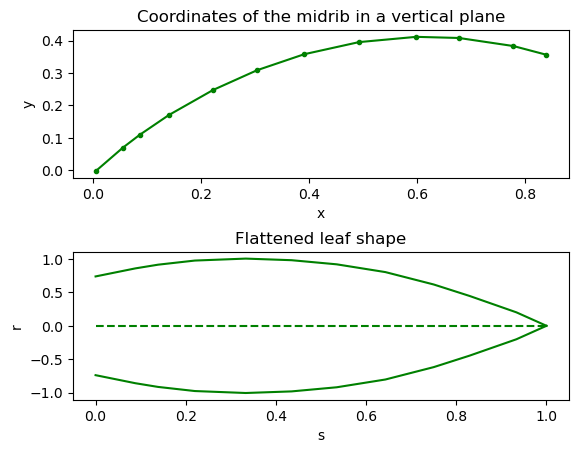

In [4]:
## Imports

# from installed packages
import numpy as np
import matplotlib.pyplot as plt
from heapq import *
from scipy.interpolate import splprep, splev
from scipy.integrate import simps, trapz
from openalea.plantgl.all import Vector3

# from openalea.openalea.archicrop
from openalea.archicrop.cereals_leaf import leaf_shape_perez, sr_prevot, parametric_leaf
# or
# from openalea.openalea.archicrop.simple_maize import leaf_shape_perez, sr_prevot, parametric_leaf
# from openalea.openalea.archicrop.fitting import leaf_shape_perez
from openalea.archicrop.generator import curvilinear_abscisse
from openalea.archicrop.fitting import fit2, fit3, simplify
from openalea.archicrop.simplification import distance, cost

## Code for generating a parametric leaf for a cereal 
pl=parametric_leaf(nb_segment=10, insertion_angle=40, scurv=0.7, curvature=70, alpha=-2.3)

fig, (ax1, ax2) = plt.subplots(nrows=2) 
# fig.suptitle('Parametric leaf')

ax1.plot(pl[0], pl[1], '.-', c="green")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title("Coordinates of the midrib in a vertical plane")

ax2.plot(pl[2], pl[3], '-', c="green")
ax2.plot(pl[2], -pl[3], '-', c="green")
ax2.plot(np.arange(0,1.1,0.1), np.zeros(11), c="green", ls="dashed")
ax2.set_xlabel('s')
ax2.set_ylabel('r')
ax2.set_title("Flattened leaf shape")

plt.subplots_adjust(hspace=0.5)

plt.show()

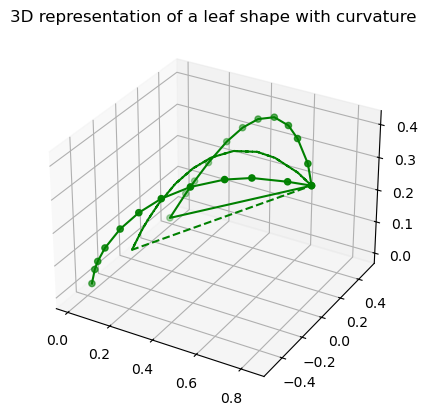

In [5]:
## Imports

# from installed packages
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import interp2d
import matplotlib.tri as mtri

# from openalea.archicrop
from openalea.archicrop.fitting import leaf_to_mesh_2d

## Code for representing the parametric leaf in 3D (ignore excess lines)
x=pl[0]
y=pl[1]
s=pl[2]
r=pl[3]

pts,ind=leaf_to_mesh_2d(x, y, r)

xs=[pt[0] for pt in pts]
ys=[pt[1] for pt in pts]
zs=[pt[2] for pt in pts]
    
X,Y=np.meshgrid(xs, ys)

tri=mtri.Triangulation(xs, ys)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.scatter(xs,ys,zs,c="green")
ax.plot(xs,ys,zs,c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")
ax.set_title("3D representation of a leaf shape with curvature")
plt.show()

Please ignore excess straight lines.

In [6]:
# from openalea.archicrop
from openalea.archicrop.cereals_leaf import parametric_leaf
from openalea.archicrop.geometry import leaf_mesh_for_growth, stem_mesh

def simple_leaf(leaf, ratio):
    total_length = 80
    lw_ratio = 7.0

    L_shape = total_length
    Lw_shape = total_length / lw_ratio
    length = total_length * ratio
    s_base = 0
    s_top = 1.0

    return leaf_mesh_for_growth(leaf, L_shape, Lw_shape, length, s_base, s_top)


In [7]:
import matplotlib.pyplot as plt
from openalea.plantgl.all import Vector3
from oawidgets.plantgl import *

# leaf = parametric_leaf(insertion_angle=30, scurv=0.6, curvature=130, alpha=-2.3)
leaf = parametric_leaf(insertion_angle=45, scurv=0.7, curvature=90, alpha=-2.3)
mesh = simple_leaf(leaf, 1) 

PlantGL(mesh)

# 326400

Plot(antialias=3, axes=['x', 'y', 'z'], axes_helper=1.0, axes_helper_colors=[16711680, 65280, 255], background…

## Generate leaf azimuth series

Leaves grow around an axis with a given phyllotaxy, represented here as an angle from leaf to leaf (e.g. spiral with a given angle or alternate distichous = $180^o$).  

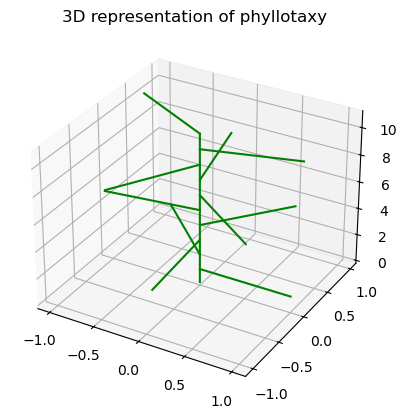

In [8]:
## Imports

# from installed packages 
# from itertools import cycle

# from openalea.archicrop
from openalea.archicrop.plant_design import leaf_azimuth

## Code for generating leaf azimuths series for a given phyllotaxy
nb_phy=10
phyllotactic_angle=137
spiral=True
phyllotactic_deviation=0
plant_orientation=0

la=leaf_azimuth(size=nb_phy, 
                phyllotactic_angle=phyllotactic_angle, 
                phyllotactic_deviation=phyllotactic_deviation, 
                plant_orientation=plant_orientation, 
                spiral=spiral)

x=np.cos(la*np.pi/180)
y=np.sin(la*np.pi/180)
z=np.linspace(1,len(la)+1,len(la))

fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of phyllotaxy")

plt.show()

## Manage internode lengths

Internodes on an axis have varying lengths. The repartition of their lengths along the axis can be approximated with a geometric model.

In [9]:
## Imports
from openalea.archicrop.plant_shape import geometric_dist

## Code for applying lengths to internodes according to a geometric model
plant_height=15
q=1.5

x=np.cos(la*np.pi/180)
y=np.sin(la*np.pi/180)
z=geometric_dist(height=plant_height, 
                   nb_phy=nb_phy, 
                   q=q)

fig,ax=plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of the repartition of internode length along the stem")

plt.show()

TypeError: geometric_dist() missing 1 required positional argument: 'u0'

In [ ]:
from openalea.archicrop.plant_shape import collar_heights_kaitaniemi, geometric_dist

nb_phy = 10
height = 100

collar_heights = collar_heights_kaitaniemi(height, nb_phy)
print(collar_heights)

collar_heights_geom = geometric_dist(height, nb_phy, 1.1)

plt.plot(range(nb_phy), collar_heights)
plt.plot(range(nb_phy), collar_heights_geom)
plt.scatter(range(nb_phy), collar_heights_geom)
plt.show()

## Manage leaf lengths as a function of height

Leaves that grow on an axis have varying lengths. The repartition of their lengths along the axis can be approximated with a bell shaped model.

In [10]:
## Imports
from openalea.archicrop.plant_shape import bell_shaped_dist

## Code for applying lengths to leaves according to a bell shaped model
max_leaf_length=50

bsd=bell_shaped_dist(max_leaf_length=max_leaf_length, 
                     nb_phy=nb_phy, 
                     rmax=.8, 
                     skew=0.15)

x=np.cos(la*np.pi/180)*bsd
y=np.sin(la*np.pi/180)*bsd
z=geometric_dist(height=plant_height, 
                   nb_phy=nb_phy, 
                   q=q)

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
for i,a in enumerate(la):
    ax.plot(np.linspace(0,x[i],2), np.linspace(0,y[i],2), [z[i],z[i]], c="green")
ax.plot([0,0], [0,0], [0,z[-1]], c="green")

ax.set_title("3D representation of the repartition of leaf length along the stem")

plt.show()

TypeError: geometric_dist() missing 1 required positional argument: 'u0'

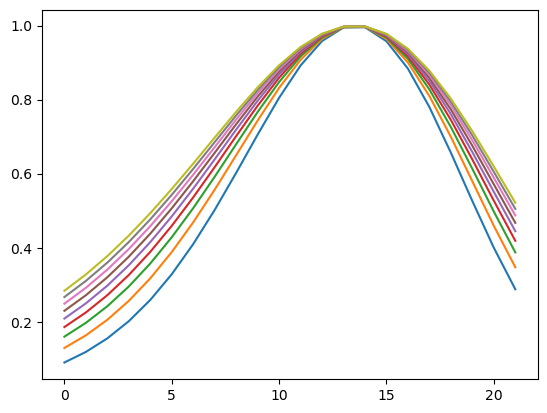

In [23]:
import matplotlib.pyplot as plt

# from openalea.archicrop.plant_shape import bell_shaped_dist

def bell_shaped_dist(max_leaf_length, nb_phy, rmax, skew):
    """returns leaf area of individual leaves along bell shaped model"""
    k = -np.log(skew) * rmax
    r = np.linspace(1.0 / nb_phy, 1, nb_phy)
    relative_length = np.exp(-k / rmax * (2 * (r - rmax) ** 2 + (r - rmax) ** 3))
    # leaf_length = relative_length / relative_length.sum() * 100 --> percentage of total leaf lengths --> same for areas
    leaf_length = relative_length * max_leaf_length
    return leaf_length.tolist()
    

max_leaf_length = 1
nb_phy = 22
rmax = 0.66
skew = 0.05
for skew in np.arange(0.01, 0.1, 0.01):
    leaf_lengths = bell_shaped_dist(max_leaf_length, nb_phy, rmax, skew)
    plt.plot(range(len(leaf_lengths)), leaf_lengths)

plt.show()

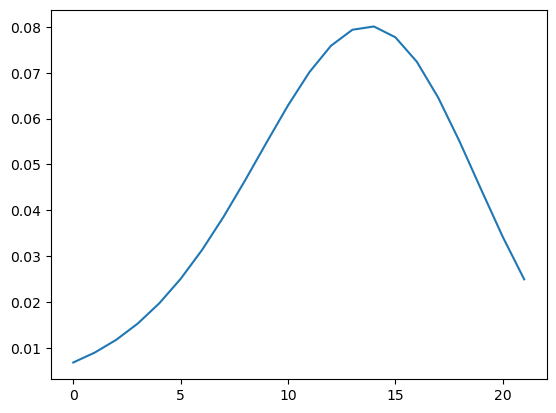

In [28]:
from openalea.archicrop.cereals_leaf import sr_prevot

def normalized_leaf_area_distribution(leaf_lengths, wl):
    leaf_areas = []
    for L in leaf_lengths:
        leaf_areas.append(2*0.749908422143643*wl*L**2)
    # Normalize the leaf_areas so their sum equals 1
    total_area = sum(leaf_areas)
    normalized_leaf_areas = [area / total_area for area in leaf_areas]
    return normalized_leaf_areas

leaf_lengths = bell_shaped_dist(max_leaf_length=1, nb_phy=22, rmax=0.67, skew=0.1)
wl = 0.12

leaf_areas = normalized_leaf_area_distribution(leaf_lengths, wl)
plt.plot(range(len(leaf_areas)), leaf_areas)
plt.show()

In [24]:
1.51657508881031-0.766666666666667

0.749908422143643

In [25]:
2*0.749908422143643

1.499816844287286

## Arrange a leaf to be placed along a stem with a given inclination.

A leaf must undergo a translation to be placed against the surface of the stem (tangent to it), and a rotation to be tilted like the stem (inclination = 1 if main stem).

In [ ]:
## Imports

# from installed packages
from math import pi, cos, sin, radians
import openalea.plantgl.all as pgl

# from openalea.archicrop
# from openalea.archicrop.cereals_leaf import arrange_leaf
# or 
from openalea.archicrop.geometry import arrange_leaf

## Code for placing a leaf against a stem element (here a cylinder), with a given inclination
stem_diameter=0.5
inclination=1

al=arrange_leaf(leaf=pl, 
                stem_diameter=stem_diameter, 
                inclination=inclination, 
                relative=True)

x=al[0]
y=al[1]
s=al[2]
r=al[3]

pts,ind=leaf_to_mesh_2d(x, y, r)

xs=[pt[0] for pt in pts]
ys=[pt[1] for pt in pts]
zs=[pt[2] for pt in pts]
    
X,Y=np.meshgrid(xs, ys)

tri=mtri.Triangulation(xs, ys)

fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.plot(xs,ys,zs,c="green")
ax.plot([xs[0],xs[0]],[ys[0],-ys[0]],[0,0],c="green")
ax.plot(xs,np.zeros(len(ys)),zs,c="green",ls="dashed")

radius=stem_diameter/2
z=np.linspace(-zs[-1], zs[-1])
theta=np.linspace(0, 2*np.pi)
theta_grid, z_stem=np.meshgrid(theta, z)
x_stem=radius*np.cos(theta_grid)
y_stem=radius*np.sin(theta_grid)

ax.plot_surface(x_stem, y_stem, z_stem, color="green")

ax.set_title("3D representation of the placement of a leaf along a stem")

plt.show()

## Build the whole plant shoot in 3D, as an MTG.

An MTG (Multiscale Tree Graph) is created as a representation of a parametrized cereal shoot.  
The different scales are: 
- Plant  
- Axis  
- Stem / Leaf   

In [ ]:
## Imports

# from installed packages
import openalea.plantgl.all as pgl
from openalea.mtg.turtle import TurtleFrame
from openalea.mtg import MTG, fat_mtg
from scipy.interpolate import interp1d
import pandas

# from openalea.archicrop
from openalea.archicrop.cereals import build_shoot


## Display scenes according to different scenarii

In [ ]:
## Imports

# from installed packages
from oawidgets.plantgl import *

# Set nice color for plants
nice_green=Color3((50,100,0))

### A single cereal

In [ ]:
## Imports

# from installed packages
from oawidgets.plantgl import *

# from openalea.archicrop
from openalea.archicrop.display import display_mtg, build_scene, display_scene

# Enable plotting with PlantGL
%gui qt

## Code for generating a 3D cereal shoot from descritive parameters
# Parameters 
height=220                 
nb_phy=22 # (15, 25, 35) # 22
max_leaf_length=90 # (60, 90, 120) # 90





shoot, g = build_shoot(nb_phy=nb_phy,
                        height=height,
                        max_leaf_length=max_leaf_length,
                        wl=0.12, # (0.1, 0.13) # 0.12
                        diam_base=2.5, 
                        diam_top=0.5, 
                        insertion_angle=30, # (30, 60) # 30
                        scurv=0.6, # (0.3, 0.6, 0.9) # 0.6
                        curvature=135, # (0, 45, 90, 135) # 130
                        alpha=-2.3, 
                        stem_q=1, # (1, 1.1)
                        rmax=0.67, 
                        skew=0.05, # 0.0005
                        phyllotactic_angle=180,
                        phyllotactic_deviation=0)

# Build and display scene
scene, nump = build_scene(g, 
                                 leaf_material=Material(nice_green), 
                                 stem_material=Material(nice_green))
# display_scene(scene_single) # display in separate window
PlantGL(scene) # display in notebook

In [ ]:
for id in g.vertices():
    print(g[id])

Let's dig into the propreties of the MTG of a cereal shoot.

In [ ]:
## Imports

# from installed packages
from oawidgets.mtg import *


## Code for exploring the MTG of the generated cereal shoot

# Properties on the MTG: this exclude all the topological properties
print(g.property_names())

# Retrieve one property for the MTG (dict)

labels = g.property('label')
# print(labels)

i_length = g.property('mature_length')
l_length = g.property('mature_length')

leaf_lengths=[]
leaf_ind=[]
internode_lengths=[]
internode_ind=[]
for k,v in i_length.items():
    internode_ind.append(k)
    internode_lengths.append(v)
for k,v in l_length.items():
    leaf_ind.append(k)
    leaf_lengths.append(v)



plt.figure()
plt.plot(leaf_ind, leaf_lengths, c="green", label="Leaf lengths") # == 'shape_mature_length' for final plant
plt.plot(internode_ind, internode_lengths, c="orange", label="Internode lengths")
plt.plot(internode_ind, np.cumsum(internode_lengths), c="orange", label="Plant height", ls='--')
plt.xlabel("Vertices")
plt.ylabel("Lengths (cm)")
plt.title("MTG properties")
plt.legend()
plt.show()

The leaf lengths and widths follow the bell shaped curve described before.  
The first internode in the MTG actually corresponds to the pseudostem, i.e. the about 4 to 8 short first internodes that rapidly lose their leaves. The lengths following internodes follow the geometric model described before.

In [ ]:
#| echo: false

classes = list(set(g.class_name(vid) for vid in g.vertices() if g.class_name(vid)))
print(classes)

def vertices(g, class_name='P'):
    return [vid for vid in g.vertices() if g.class_name(vid)==class_name]

vids_U = vertices(g, 'U')

plot(g, selection=vids_U)

plot(g, selection=[vid for vid in g.vertices() if g.class_name(vid)=='LeafElement'])

### A cereal crop with variability

In [ ]:
## Imports

# from installed packages
from random import *

# from openalea.archicrop
from openalea.archicrop.stand import agronomic_plot

# Enable plotting with PlantGL
%gui qt

## Code for generating a random cereal crop from descritive parameters with variability 
# Fix a seed
#seed(1)

# Initialize the list of plants
plants_in_crop=[]

# Fixed parameters for all plants
length_plot=5
width_plot=5
sowing_density=10
plant_density=5
inter_row=0.5
nplants, positions, domain, domain_area, unit = agronomic_plot(length_plot, 
                                                               width_plot, 
                                                               sowing_density,  
                                                               inter_row, 
                                                               noise=0.1)

# For loop over all the plants in the crop
for n in range(nplants):
    # Parameters varying among plants
    height=150*(1+random()-0.5) 
    nb_phy=17
    max_leaf_length=60*(1+random()-0.5)
    insertion_angle=45*(1+random()-0.5)
    scurv=0.7*(1+random()-0.5)
    curvature=70*(1+random()-0.5)
    phyllotactic_deviation=15*(1+random()-0.5)

    # Functions calls
    shoot, g_var = build_shoot(nb_phy=nb_phy, height=height, max_leaf_length=max_leaf_length, 
                                wl=0.1, diam_base=2.5, diam_top=1.0, 
                                insertion_angle=insertion_angle, scurv=scurv, curvature=curvature, 
                                alpha=-2.3, stem_q=1.1, rmax=0.7, skew=0.05,
                                phyllotactic_angle=180, phyllotactic_deviation=phyllotactic_deviation, plant_orientation=45, spiral=True)

    # Fill the list of plants
    plants_in_crop.append(g_var)

# Build and display scene
scene_var, nump = build_scene(plants_in_crop, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
# display_scene(scene_var)
PlantGL(scene_var)

### An intercrop organized in rows

In [ ]:
## Imports

# from installed packages
from openalea.plantgl.all import Material, Color3, Shape, Scene, Viewer, Translated, AxisRotated

# Enable plotting with PlantGL
%gui qt

## Code for generating an intercrop from descritive parameters

# Fix a seed
seed(1)

def plant(height, nb_phy, max_leaf_length, phyllotactic_angle):
    """ return the MTG of a cereal shoot generative from descriptive parameters """
    
    shoot, g = build_shoot(nb_phy=nb_phy, height=height, max_leaf_length=max_leaf_length, phyllotactic_angle=phyllotactic_angle, plant_orientation=45)
    return g


# Organize the plant mixture in alternate rows
n_rows = 10
len_rows = 10

d_inter = 70
d_intra = 50

def plant_in_row(i):
     if i%(4*d_inter)==0 or i%(4*d_inter)==d_inter: return plant(height=1700, nb_phy=18, max_leaf_length=100, phyllotactic_angle=137)
     else: return plant(height=900, nb_phy=18, max_leaf_length=40, phyllotactic_angle=60)


plants_in_intercrop = [plant_in_row(x) for x in range(0, n_rows*d_inter, d_inter) for y in range(0, len_rows*d_intra, d_intra)]

positions=[(x,y,0) for x in range(0, n_rows*d_inter, d_inter) for y in range(0, len_rows*d_intra, d_intra)]

# Build and display scene
scene_ic, nump = build_scene(plants_in_intercrop, positions, leaf_material=Material(nice_green), stem_material=Material(nice_green))
# display_scene(scene_ic)
PlantGL(scene_ic)

## Tillering / Branching

First, basipetal tillers, straight, oriented according to a certain angle, appearing according to a certain timing  

Parameters : number, maximal order, reduction factor, tiller appearance rate (>1 phyllochron or not? several mechanisms depending on species, keep it simple at first), insertion angle (same as leaf ?), tiller curvature, condition related to density (ex: hyp sorghum im field --> no tiller)

For the final structure: When visiting the phytomers from the base, the tillers will be allocated sequentially to the short internodes, following their age and, for a given age, following the ascending order of tiller order, in the limits of the total number of tillers and the maximal order allowed for tillers. Some geometrical features (length, stem diameter, max leaf length, etc.) will be reduced by a given reduction ratio (order-dependent ?). The angles of the tillers 

How do we manage the leaves of the short internodes bearing tillers ? Do we consider them at all ?  

For growth: the age (start_tt and end_tt) is determined by a tiller appearance rate, expressed as a function of the phyllochron (and the order ?)   

see weberpenn
Ecomeristem
Evers
Abichou